In [137]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from sympy import conjugate

def bloch_sphere(circuit):
    state = Statevector(circuit)
    return plot_bloch_multivector(state)

def inner_product(v,w):
    d = len(v); ip = 0
    for j in range(0,d):
        ip += conjugate(v[j])*w[j]
    return ip

In [148]:
# gerando os estados aleatórios
c0 = np.random.rand()**0.5
c1 = (1.0 - c0**2)**0.5
target_state = np.array([[c0],[c1]])
print(target_state)

[[0.87477154]
 [0.48453561]]


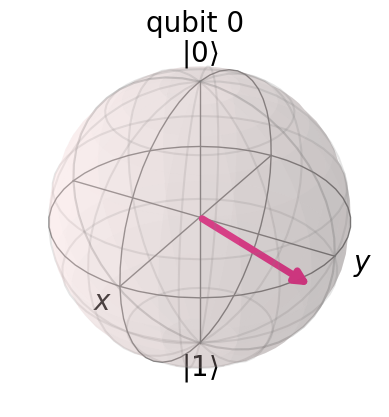

In [149]:
params = np.random.normal(0, np.pi/2, (2), requires_grad=True)
qc = QuantumCircuit(1)
qc.rx(params[0].item(),0)
qc.ry(params[1].item(),0)
bloch_sphere(qc)

### Fidelidade

* Estados puros $ F(\rho,\sigma) = Tr[\rho\sigma\rho]^{1/2} = Tr[|\phi\rangle\langle\phi|\psi\rangle\langle\psi|\phi\rangle\langle\phi|]^{1/2} = |\langle\psi|\phi\rangle|$.

* Estados que são diagonais numa mesma base (comutativos) $ F(\rho,\sigma) = \sum_i\sqrt{p_iq_i} $

In [ ]:
def fidelity(rho1, rho2):
    a=0

In [150]:


device = qml.device('qiskit.aer', wires=1, backend='qasm_simulator')
@qml.qnode(device, diff_method='parameter-shift')
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))
params = np.random.normal(0, np.pi/2, (2), requires_grad=True)
qc = circuit(params)


In [152]:
theta = 2*np.arccos(c0)
target_expectedValue = np.cos(theta)
print(target_expectedValue)

0.5304504768990568


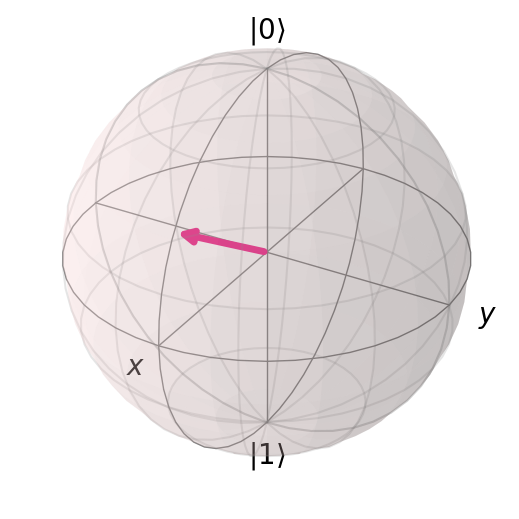

In [151]:
from qiskit_textbook.widgets import plot_bloch_vector_spherical
theta = 2*np.arccos(c0)
target_expectedValue = np.cos(theta)
phi = 0
coords = [theta, phi, 1]

plot_bloch_vector_spherical(coords)

In [ ]:
def vqa_prep(target_state, device):
    device = qml.device('qiskit.aer', wires=1, backend='qasm_simulator')
    params = np.random.normal(0, np.pi/2, (2), requires_grad=True)
    @qml.qnode(device, diff_method='parameter-shift')
    def circuit(params):
        qml.RX(params[0], wires=0)
        qml.RY(params[1], wires=0)

        return qml.expval(qml.PauliZ(0))

In [ ]:
device = qml.device('qiskit.aer', wires=1, backend='qasm_simulator')

params = np.random.normal(0, np.pi/2, (2), requires_grad=True)

@qml.qnode(device, diff_method='parameter-shift')

def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)

    return qml.expval(qml.PauliZ(0))

fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

In [ ]:
def loss(params):
    L = abs(target_expectedValue - circuit(params))
    return L
opt = qml.AdamOptimizer(stepsize=0.01)

for i in range(256):
    print(loss(params), circuit(params), target_expectedValue)
    params = opt.step(loss, params)

In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(1)
qc.rx(params[0].item(),0)
qc.ry(params[1].item(),0)

from qiskit.visualization import visualize_transition
visualize_transition(qc)